# Assignment 2 
- 1D 2 class Gaussian Discriminent
- 2D 2 class Gaussian Discriminent
- kD k class Gaussian Discriminent
### setting all the imports


In [229]:
# all imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import re
from sklearn import datasets, linear_model
from sklearn.cross_validation import KFold    
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from numpy.linalg import inv
from sklearn.preprocessing import PolynomialFeatures
import collections # this is used to perform the collection  based sorting  and unique element identification
from sklearn.cross_validation import train_test_split #  this is used for cross validation 
from functools import partial # this is to accomdate partials
import random
from numpy.linalg import inv

### This a class tha twould be used to test the data set

In [230]:
class TestMetrics:
    
    def setData(self,y_test,y_pred_class):
            self.y_test = y_test
            self.y_pred_class = y_pred_class
#             print 'True:', y_test
#             print 'Pred:', y_pred_class
        
    def getMatrics(self):
        #print metrics.accuracy_score(self.y_test, self.y_pred_class)
        # save confusion matrix and slice into four pieces
        confusion = metrics.confusion_matrix(self.y_test, self.y_pred_class)
#         print "confusion matrix:",confusion
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        
        #Classification Accuracy: Overall, how often is the classifier correct?
        Classification_Accuracy = (TP + TN) / float(TP + TN + FP + FN)
        #print "#Classification Accuracy:\t",Classification_Accuracy
        # print metrics.accuracy_score(y_test, y_pred_class)
        
        #Classification Error: Overall, how often is the classifier incorrect?
        Classification_Error = (FP + FN) / float(TP + TN + FP + FN)
        #print "#Classification Error:\t",Classification_Error
        #print 1 - metrics.accuracy_score(y_test, y_pred_class)
        
        #Sensitivity:
        Sensitivity = TP / float(TP + FN)
        #print "#Sensitivity:\t",Sensitivity
        #print metrics.recall_score(y_test, y_pred_class)
        #Specificity: 
        Specificity = TN / float(TN + FP)
        #print "#Specificity:\t",Specificity
        #False Positive Rate:
        False_Positive_Rate = FP / float(TN + FP)
        #print "#False Positive Rate:",False_Positive_Rate
        #Precision: 
        Precision = TP / float(TP + FP)
        #print "#Precision:\t",Precision
        #print metrics.precision_score(y_test, y_pred_class)
        #print TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision
        return TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision
#test        
# tm  = TestMetrics()
# tm.setData(Y,Y)
# tm.getMatrics()

In [231]:
# fetching all data

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:]  # we only take the first two features.
Y = iris.target

numberOfClass = lambda listValues :list(set(listValues))# this is the number of classes in each dataset

m = lambda listValues: collections.Counter(listValues)

idf = lambda currentClass,itratingClass : (0,1)[currentClass == itratingClass] # this is the indicator function

mean = lambda X_D,Y_D:[np.mean([idf(Y_D[rowIndex],classElement)*rowElements for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1],axis = 0) for classIndex ,classElement in enumerate(numberOfClass(Y_D))]

varience =lambda X_D,Y_D:[np.var([idf(Y_D[rowIndex],classElement)*rowElements for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1],axis = 0) for classIndex ,classElement in enumerate(numberOfClass(Y_D))]

alpha = lambda X_D,Y_D:[m(Y_1D)[classElement]*1.0/len(Y_D) for classElement in (numberOfClass(Y_D))]
# this is for 1D calculation
g = lambda x,var,mean,alpha: np.log2(alpha)- (((x-mean)**2)/2*(var**2))

covVar =  lambda X_D,Y_D:[np.cov(np.array([idf(Y_D[rowIndex],classElement)*rowElements for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1]).T) for classIndex,classElement in enumerate(numberOfClass(Y_D))]
# this is for 2D calcultaion
g_multiVariate = lambda x,co_var_mat,mean: ((2*np.dot(np.dot(x.T,inv(co_var_mat)),mean)) - (np.dot(np.dot(mean.T,inv(co_var_mat)),mean)))

# discriminent = lambda x,a_class,b_class : (1,0)[ a_class(x) > b_class(x) ]
# discriminent = lambda x,a_class,b_class: 1 if  a_class(x)>b_class(x) else 0                                           
def discriminent (x, a_class, b_class):
    sendX = (np.asarray([x])).T # sending x as a collection of rows vector
    if a_class(sendX)>b_class(sendX):
        return 1
    else :
        return 0

# test 
#covVar(X,Y)



In [232]:
class GDA1D2C:
    #this si to fit the existing data
    def fit(self,Xdata,Ydata):
        self.XData = Xdata
        self.YData = Ydata
        #step:1 - find alpha
        self.alpha = alpha(Xdata,Ydata)
#         print "alpha"
#         print self.alpha
        #step:2 - find mean 
        self.mean = mean(Xdata,Ydata)
        #print "mean",self.mean
        #step:3 - find varience
        self.varience = varience(Xdata,Ydata)
        #print"varience",self.varience
        #step:4
        g0 = partial(g,var = self.varience[0],mean= self.mean[0],alpha= self.alpha[0])
        g1 = partial(g,var = self.varience[1],mean= self.mean[1],alpha= self.alpha[1])
        #step:5
        self.discriminent = partial(discriminent,a_class = g0, b_class = g1)
        #self.discriminent = partial(discriminent,a_class = partial(g,varience = self.varience[0],mean= self.mean[0],alpha= self.alpha[0]), b_class = partial(g,varience = self.varience[1],mean= self.mean[1],alpha= self.alpha[1]))
    # this is to predict y data  from the give X data
    def predict(self,XD):
        return [self.discriminent(xvalue) for xvalue in XD]

In [233]:
class GDAnD2C:
    #this si to fit the existing data
    def fit(self,Xdata,Ydata):
        self.XData = Xdata
        self.YData = Ydata
    
        #step:2 - find mean 
        self.mean = mean(Xdata,Ydata)
        #print "mean",self.mean
        
        #step:3 - find co_varience
        self.co_varience = covVar(Xdata,Ydata)
        #print"co varience matix",self.co_varience
        
        #step:4
        #print "mean--------", ((np.asarray([self.mean[0]])).T).shape
        
        ## sending the mean as transposed
        self.g0 = partial(g_multiVariate,co_var_mat = self.co_varience[0],mean= (np.asarray([self.mean[0]])).T)
        self.g1 = partial(g_multiVariate,co_var_mat = self.co_varience[1],mean= (np.asarray([self.mean[1]])).T)
        #step:5
        self.discriminent = partial(discriminent,a_class = self.g0, b_class = self.g1)
        #self.discriminent = partial(discriminent,a_class = partial(g,varience = self.varience[0],mean= self.mean[0],alpha= self.alpha[0]), b_class = partial(g,varience = self.varience[1],mean= self.mean[1],alpha= self.alpha[1]))
    # this is to predict y data  from the give X data
    def predict(self,XD):
        return [self.discriminent(xvalue) for xvalue in XD]

   Accuracy  Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0       0.1    0.9   1   8             1.000000   0.111111     0.500000   
1       0.3    0.7   2   5             1.000000   0.375000     0.600000   
2       0.1    0.9   5   4             1.000000   0.200000     0.166667   
3       0.1    0.9   4   5             1.000000   0.166667     0.200000   
4       0.2    0.8   3   5             0.833333   0.166667     0.250000   

   Specificity  TN  TP  
0     0.000000   0   1  
1     0.000000   0   3  
2     0.000000   0   1  
3     0.000000   0   1  
4     0.166667   1   1  


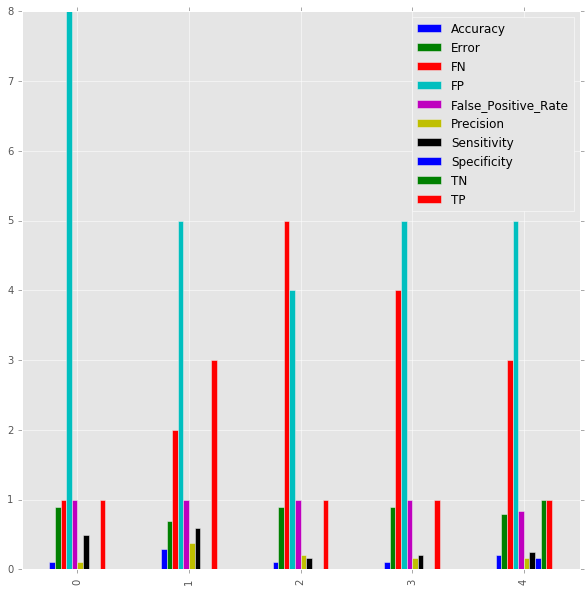

In [234]:

X_1D = X[:100,:1]# this is to take one feature and first 100 data sets
Y_1D = Y [:100] # this is to take 1st 100 data sets


matricsTotal = []
kf = sklearn.cross_validation.KFold(n=len(Y_1D), n_folds=10, shuffle=True,random_state=5)
for train_index, test_index in kf:
    #print train_index
#     X_train, X_test, Y_train, Y_test = train_test_split(X_1D, Y_1D, test_size=0.4, random_state= a)
    X_train, X_test =[list(X_1D[a]) for a  in train_index],[list(X_1D[a]) for a  in test_index]
    Y_train, Y_test = [Y_1D[a] for a  in train_index],[Y_1D[a] for a  in test_index]
#     print X_train
#     #     print Y_train
#     print "\n\n"
    grad =  GDA1D2C()
    grad.fit(X_train,Y_train)
    predicted_Y_values = grad.predict(X_test)
    tm  = TestMetrics()
    tm.setData(Y_test,predicted_Y_values)
    TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  tm.getMatrics()
    matricsTotal.append({"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})


df = pd.DataFrame(matricsTotal).head()

matplotlib.style.use('ggplot')
#df.plot.figure(figsize=(50,50))
df.plot(kind = 'bar',figsize =(10 ,10),stacked = False)

print df

# Checking with 2 class n features Gaussian discreminent

   Accuracy  Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0       0.2    0.8   0   8                    1        0.2            1   
1       0.5    0.5   0   5                    1        0.5            1   
2       0.6    0.4   0   4                    1        0.6            1   
3       0.5    0.5   0   5                    1        0.5            1   
4       0.4    0.6   0   6                    1        0.4            1   

   Specificity  TN  TP  
0            0   0   2  
1            0   0   5  
2            0   0   6  
3            0   0   5  
4            0   0   4  


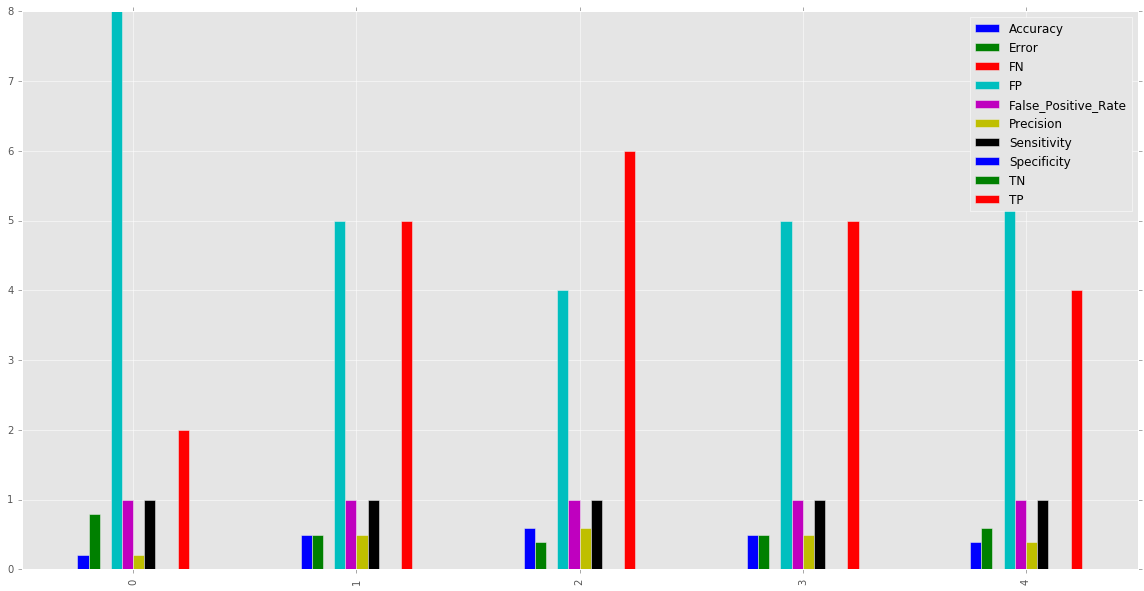

In [239]:
X_2D = X[:100,:]# this is to take one feature and first 100 data sets
Y_2D = Y [:100] # this is to take 1st 100 data sets



#print np.sum(X_12)/50
#print Y_1D.size
# print X_1D
# print Y_1D
# print len(X_1D)
# print alpha(X_1D,Y_1D)
# print mean(X_1D,Y_1D)
# print varience(X_1D,Y_1D)[0]
# STEP 1: split X and y into training and testing set
matricsTotal = []
kf = sklearn.cross_validation.KFold(n=len(Y_1D), n_folds=10, shuffle=True,random_state=5)
for train_index, test_index in kf:
    #print train_index
#     X_train, X_test, Y_train, Y_test = train_test_split(X_1D, Y_1D, test_size=0.4, random_state= a)
    X_train, X_test =[X_2D[a] for a  in train_index],[X_2D[a] for a  in test_index]
    Y_train, Y_test = [Y_2D[a] for a  in train_index],[Y_2D[a] for a  in test_index]
#     print X_train
#     #     print Y_train
#     print "\n\n"
    grad =  GDAnD2C()
    grad.fit(X_train,Y_train)
    predicted_Y_values = grad.predict(X_test)
    tm  = TestMetrics()
    tm.setData(Y_test,predicted_Y_values)
    TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  tm.getMatrics()
    matricsTotal.append({"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})


df = pd.DataFrame(matricsTotal).head()

matplotlib.style.use('ggplot')
#df.plot.figure(figsize=(50,50))
df.plot(kind = 'bar',figsize =(20 ,10),stacked = False)

print df


In [240]:
asdf = np.array([[1,2,4]])
print (asdf.T).shape

(3L, 1L)


In [237]:
a = [1, 2]
asd = np.asarray([list(a)])
print asd.T

[[1]
 [2]]
